### The previous notebook was starting to get muddled, so I am creating a new one with the correct order:
     * dynamically winsorize data w moving average
     * optimize model hyperparameters 
     * compare to previous results

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit

In [3]:
st = st.Stocks()

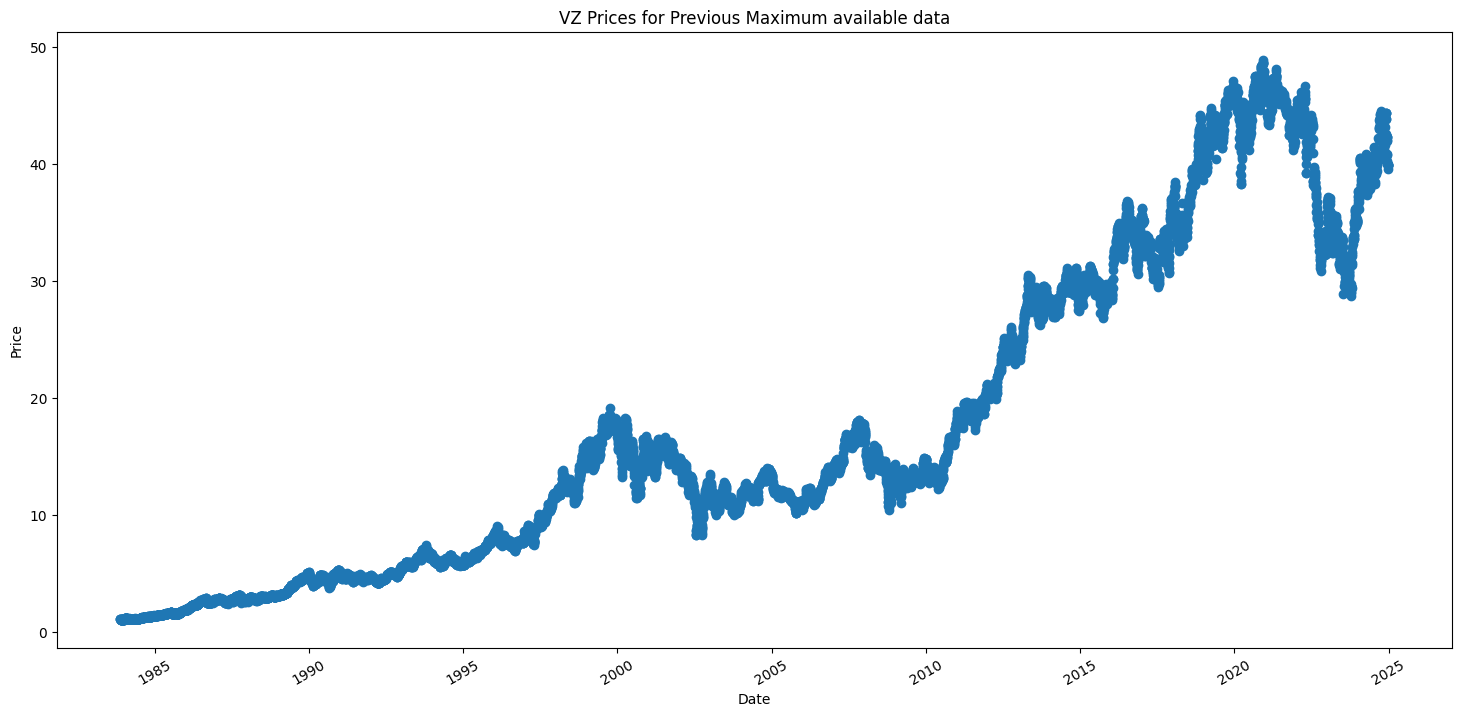

Closing price as of 2024-12-31: $39.99
The percentage change over previous Maximum available data is 3434%
Dividends total $65.71
Stock Splits total $9.11
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('vz')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1983-11-21 00:00:00-05:00,1.131467,1.133470,1.051363,1.125459,5020667,0.0,0.0
1,1983-11-22 00:00:00-05:00,1.125459,1.141480,1.119451,1.121454,2666896,0.0,0.0
2,1983-11-23 00:00:00-05:00,1.121455,1.125460,1.109439,1.115447,1151978,0.0,0.0
3,1983-11-25 00:00:00-05:00,1.115446,1.117449,1.103431,1.103431,1772000,0.0,0.0
4,1983-11-28 00:00:00-05:00,1.097424,1.097424,1.069387,1.073392,2368004,0.0,0.0


In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [8]:
df[df['Close'] != df['winsorized']].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized
30,1984-01-05,1.115446,1.139477,1.115446,1.117449,3759273,0.0,0.0,1.046257,1.116548,1.116548
31,1984-01-06,1.113444,1.145486,1.113444,1.137475,4508281,0.0,0.0,1.046257,1.116548,1.116548
32,1984-01-09,1.137475,1.137475,1.123457,1.123457,1791570,0.0,0.0,1.046257,1.120753,1.120753
33,1984-01-10,1.123456,1.127461,1.119451,1.127461,1571849,0.0,0.0,1.046257,1.125659,1.125659
34,1984-01-11,1.127462,1.133470,1.127462,1.129465,1258725,0.0,0.0,1.046257,1.128563,1.128563


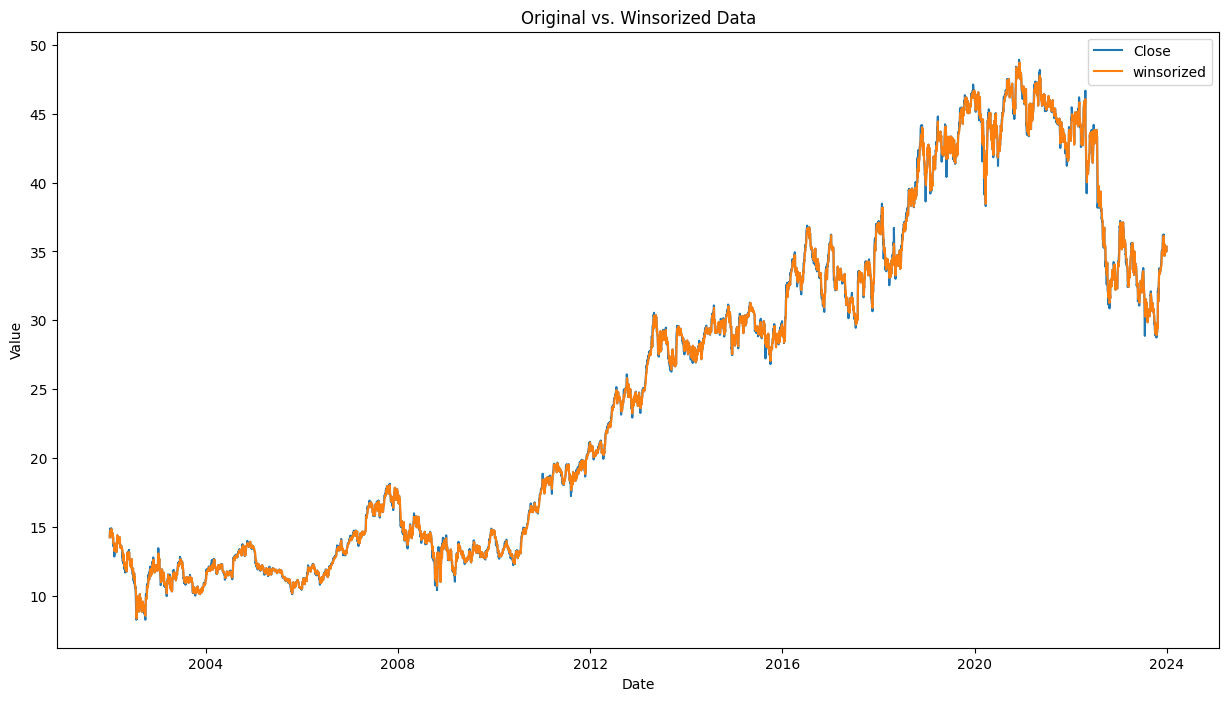

In [9]:
# zoomed view

import matplotlib.pyplot as plt
from datetime import date

# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2023, month=12, day=31)

# Filter the DataFrame based on the date range
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='Date', y=['Close', 'winsorized'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Winsorized Data')
plt.legend()

# Show the plot
plt.show()

### -- create a new baseline model --


In [10]:
# format new dataset for model with 'ds' and 'y'

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [11]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_model_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-period:]
    y_pred = forecast['yhat'][-period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [12]:
%%time

period=365

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 937 ms, sys: 193 ms, total: 1.13 s
Wall time: 4.99 s


In [13]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,4.348444,0.129118,32.790005,5.726256


In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
10721,2025-12-27,41.817600,38.958351,45.310101,41.392577,42.202152,0.327383,0.327383,0.327383,0.081402,0.081402,0.081402,0.245981,0.245981,0.245981,0.0,0.0,0.0,42.144983
10722,2025-12-28,41.819017,38.689663,45.356782,41.392199,42.205049,0.334388,0.334388,0.334388,0.081402,0.081402,0.081402,0.252986,0.252986,0.252986,0.0,0.0,0.0,42.153405
10723,2025-12-29,41.820435,38.821799,45.329670,41.391820,42.207947,0.250047,0.250047,0.250047,-0.010740,-0.010740,-0.010740,0.260788,0.260788,0.260788,0.0,0.0,0.0,42.070482
10724,2025-12-30,41.821853,38.948592,45.628558,41.391442,42.210844,0.237769,0.237769,0.237769,-0.031499,-0.031499,-0.031499,0.269268,0.269268,0.269268,0.0,0.0,0.0,42.059622
10725,2025-12-31,41.823270,38.819836,45.234439,41.391063,42.213741,0.232158,0.232158,0.232158,-0.046127,-0.046127,-0.046127,0.278285,0.278285,0.278285,0.0,0.0,0.0,42.055428


### -- for fun, i want to compare yhat with actual Close now --

In [15]:
forecast['actual_close'] = df.Close

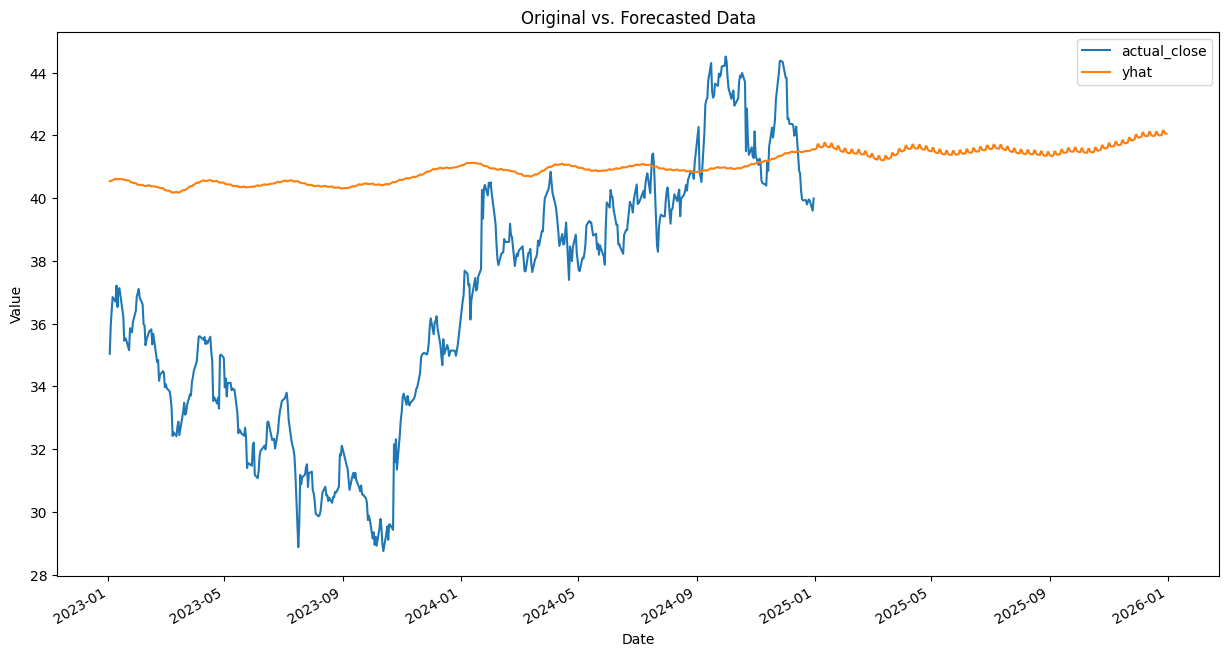

In [16]:
# Define the desired date range
start_date = date(year=2023, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

### -- Cross Validation w Grid Search --

In [17]:
%%time
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define hyperparameter grid
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
    'seasonality_prior_scale': [0.1, 1, 10] 
}

best_params = None
best_score = float('inf') 

for seasonality_mode in param_grid['seasonality_mode']:
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            # Create and fit the model
            m = Prophet(
                seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale
            )
        m.fit(df_train)
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days') 
        df_p = performance_metrics(df_cv)
        score = df_p['rmse'].mean() 

        if score < best_score:
            best_score = score
            best_params = {
                'seasonality_mode': seasonality_mode,
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale
                        }

18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/78 [00:00<?, ?it/s]

18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/78 [00:00<?, ?it/s]

18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/78 [00:00<?, ?it/s]

18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:31 - cmdstanpy - INFO - Chain [1] done processing
18:17:31 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing
18:17:32 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing
18:17:32 - cmdstanpy - INFO - Chain [1] start processing
18:17:33 - cmdstanpy - INFO - Chain [1] done processing
18:17:33 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing
18:17:34 - cmdstanpy - INFO - Chain [1] start processing
18:17:35 - cmdstanpy - INFO - Chain [1] done processing
18:17:36 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing
18:17:37 - cmdstanpy - INFO - Chain [1] start processing
18:17:38 - cmdstanpy - INFO - Chain [1] done processing
18:17:38 - cmdstanpy - INFO - Chain [1] start processing
18:17:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/78 [00:00<?, ?it/s]

18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:30 - cmdstanpy - INFO - Chain [1] done processing
18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing
18:21:31 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing
18:21:31 - cmdstanpy - INFO - Chain [1] start processing
18:21:32 - cmdstanpy - INFO - Chain [1] done processing
18:21:32 - cmdstanpy - INFO - Chain [1] start processing
18:21:32 - cmdstanpy - INFO - Chain [1] done processing
18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:34 - cmdstanpy - INFO - Chain [1] done processing
18:21:34 - cmdstanpy - INFO - Chain [1] start processing
18:21:35 - cmdstanpy - INFO - Chain [1] done processing
18:21:35 - cmdstanpy - INFO - Chain [1] start processing
18:21:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/78 [00:00<?, ?it/s]

18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
18:24:00 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1] done processing
18:24:00 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1] done processing
18:24:00 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/78 [00:00<?, ?it/s]

18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing
18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing
18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing
18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing
18:24:34 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing
18:24:34 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing
18:24:34 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing
18:24:34 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing
18:24:34 - cmdstanpy - INFO - Chain [1] start processing
18:24:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/78 [00:00<?, ?it/s]

18:25:46 - cmdstanpy - INFO - Chain [1] start processing
18:25:46 - cmdstanpy - INFO - Chain [1] done processing
18:25:46 - cmdstanpy - INFO - Chain [1] start processing
18:25:46 - cmdstanpy - INFO - Chain [1] done processing
18:25:46 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
18:25:47 - cmdstanpy - INFO - Chain [1] start processing
18:25:48 - cmdstanpy - INFO - Chain [1] done processing
18:25:48 - cmdstanpy - INFO - Chain [1] start processing
18:25:48 - cmdstanpy - INFO - Chain [1] done processing
18:25:48 - cmdstanpy - INFO - Chain [1] start processing
18:25:49 - cmdstanpy - INFO - Chain [1] done processing
18:25:49 - cmdstanpy - INFO - Chain [1] start processing
18:25:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/78 [00:00<?, ?it/s]

18:27:52 - cmdstanpy - INFO - Chain [1] start processing
18:27:53 - cmdstanpy - INFO - Chain [1] done processing
18:27:53 - cmdstanpy - INFO - Chain [1] start processing
18:27:53 - cmdstanpy - INFO - Chain [1] done processing
18:27:53 - cmdstanpy - INFO - Chain [1] start processing
18:27:53 - cmdstanpy - INFO - Chain [1] done processing
18:27:53 - cmdstanpy - INFO - Chain [1] start processing
18:27:54 - cmdstanpy - INFO - Chain [1] done processing
18:27:54 - cmdstanpy - INFO - Chain [1] start processing
18:27:54 - cmdstanpy - INFO - Chain [1] done processing
18:27:54 - cmdstanpy - INFO - Chain [1] start processing
18:27:54 - cmdstanpy - INFO - Chain [1] done processing
18:27:54 - cmdstanpy - INFO - Chain [1] start processing
18:27:55 - cmdstanpy - INFO - Chain [1] done processing
18:27:55 - cmdstanpy - INFO - Chain [1] start processing
18:27:56 - cmdstanpy - INFO - Chain [1] done processing
18:27:56 - cmdstanpy - INFO - Chain [1] start processing
18:27:56 - cmdstanpy - INFO - Chain [1]

CPU times: user 2min, sys: 11.1 s, total: 2min 11s
Wall time: 17min 8s


In [18]:
# Train the final model with the best hyperparameters
final_model = Prophet(**best_params)
final_model.fit(df_train)

18:30:01 - cmdstanpy - INFO - Chain [1] start processing
18:30:04 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 10}

In [20]:
%%time
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

  0%|          | 0/78 [00:00<?, ?it/s]

18:30:04 - cmdstanpy - INFO - Chain [1] start processing
18:30:04 - cmdstanpy - INFO - Chain [1] done processing
18:30:04 - cmdstanpy - INFO - Chain [1] start processing
18:30:05 - cmdstanpy - INFO - Chain [1] done processing
18:30:05 - cmdstanpy - INFO - Chain [1] start processing
18:30:05 - cmdstanpy - INFO - Chain [1] done processing
18:30:05 - cmdstanpy - INFO - Chain [1] start processing
18:30:05 - cmdstanpy - INFO - Chain [1] done processing
18:30:05 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1] done processing
18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1] done processing
18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:08 - cmdstanpy - INFO - Chain [1]

CPU times: user 14.9 s, sys: 1.48 s, total: 16.4 s
Wall time: 2min 9s


In [21]:
print(df_p.mean())

horizon     201 days 00:00:00
mse                 16.189614
rmse                 3.994151
mae                  2.653375
mape                 0.153688
mdape                0.131371
smape                0.151617
coverage             0.316958
dtype: object


In [22]:
future = final_model.make_future_dataframe(periods=period)
forecast = final_model.predict(future)

In [23]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,4.170486,0.124046,30.926176,5.561131


In [24]:
forecast['actual_close'] = df.Close

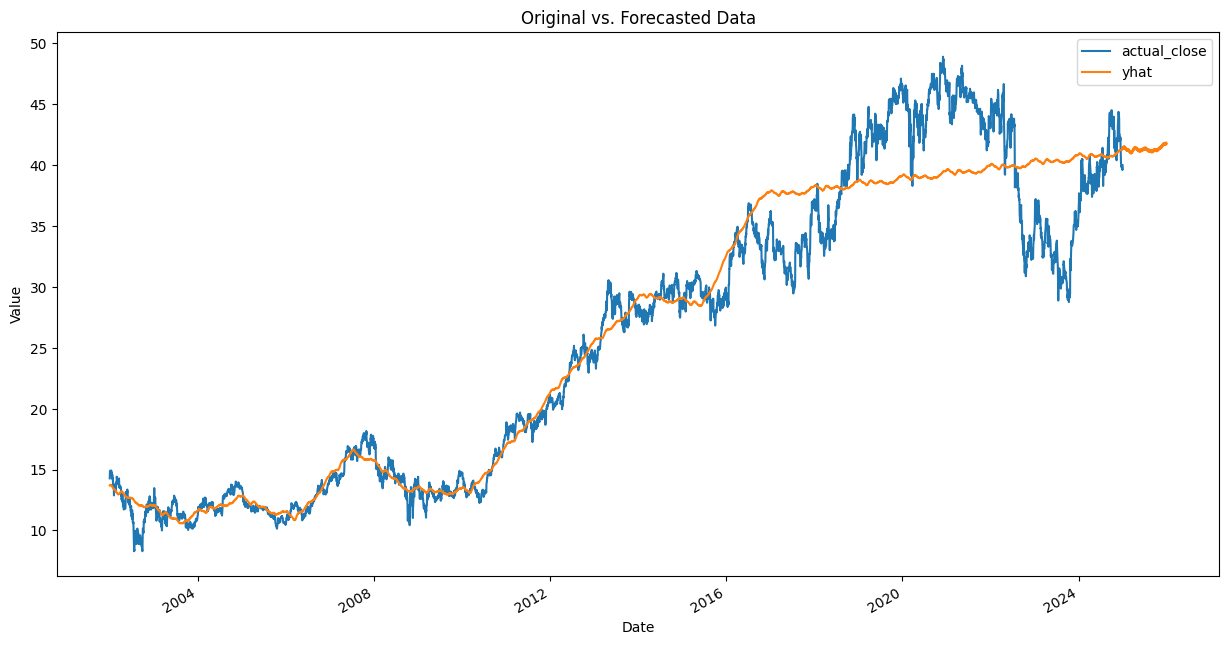

In [25]:
# Define the desired date range
start_date = date(year=2002, month=1, day=1)
end_date = date(year=2025, month=12, day=31)

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the DataFrame based on the date range
df_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
df_filtered.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot (optional)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

In [26]:
# visualize

# Plot Forecast
fig1 = plot_plotly(m, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### follow up
* gme mape results are 7.97% better with winsorization than just grid search and cross-validation! (0.310355 vs 0.390088)
    * winsorized model is 25.95% better mape than un-tuned model (0.310355 vs 0.569809)

* figure out what performance_metrics() does to calculate metrics. it is wildly different than get_model_accuracy()
    * get_model_accuracy() measures the error outside of the forecast
    * performance_metrics() measures error from cross-validation

* why is the model just a straight line? like obviously theres a pattern but it doesn't match well with actual price. or is it just GME?
    * let's fiddle w some parameters for GME, it seems like there's no changepoints

* have code evaluate given dataset (for volitility?) and put out the best model for that data

* tune changepoint_prior_scale
* tune fourier_order
* tune fourier_order